In [24]:
import pandas
import tqdm
import os
import glob
from pathlib import Path
import biotite.structure.io.pdb as pdb
import biotite.database.rcsb as rcsb
import numpy as np
import nglview as nv
import seaborn as sns
import shutil

In [2]:
# Read in df_pockets_ds_05_wpr.csv
df_pockets_ds_05_wpr = pandas.read_csv('../data/df_pockets_ds_05_wpr.csv')

In [7]:
# (Optional) Remove rows that contain more than a single underscore in the name column (to exclude subpockets)
#df_pockets_ds_05_wpr = df_pockets_ds_05_wpr[~df_pockets_ds_05_wpr['name'].str.contains('_.*_')]

In [3]:
# (Optional) Keep only rows that contain at least two underscores in the name columns (to only keep subpockets)
df_pockets_ds_05_wpr = df_pockets_ds_05_wpr[df_pockets_ds_05_wpr['name'].str.contains('_.*_.*')]

In [4]:
# Summarize df_pockets
df_pockets_ds_05_wpr.head()

,Unnamed: 0,name,lig_cov,poc_cov,lig_name,4A_crit,volume,hull,surface,lid,...,DA,DC,DG,DT,DN,UNK,simpleScore,drugScore,frame,pocket_res
1,1,P_1_1,0,0,NaN,0,698.112,832.64,748.80,83.84,...,0,0,0,0,0,0,0.657060,0.624028,0,12 15 16 19 22 23 26 27 30 40 43 44 47 77 78 8...
2,2,P_1_2,0,0,NaN,0,377.024,390.24,331.52,58.72,...,0,0,0,0,0,0,0.520508,0.602764,0,23 137 140 141 144 222 225 226 244 247 248 303...
7,21,P_1_1,0,0,NaN,0,860.928,1008.96,938.24,70.72,...,0,0,0,0,0,0,0.944457,0.775608,1,18 19 22 23 24 26 27 29 30 33 35 40 43 44 47 7...
8,30,P_1_10,0,0,NaN,0,48.448,88.48,88.00,0.48,...,0,0,0,0,0,0,0.386291,0.579631,1,5 8 9 12 112 116 128 132
9,31,P_1_11,0,0,NaN,0,38.848,71.84,71.84,0.00,...,0,0,0,0,0,0,0.170718,0.547716,1,216 217 220 221 358 361 362 365


In [5]:
# Get a list of all values in pocket_res column
pocket_res_list = df_pockets_ds_05_wpr['pocket_res'].tolist()

# Convert each element in this list to a list
pocket_res_list = [x.split(' ') for x in pocket_res_list]

# Stack all lists into a single list
pocket_res_list = [item for sublist in pocket_res_list for item in sublist]

# Convert this list to a list of integers
pocket_res_list = [int(x) for x in pocket_res_list]

# Get a list of all unique values in pocket_res_list
pocket_res_list_unique = list(set(pocket_res_list))

In [6]:
# Create a dataframe that will have a column for each unique value in pocket_res_list_unique, and another column for frame
df_pockets_ds_05_wpr_pocket_res = pandas.DataFrame(columns=['frame'] + pocket_res_list_unique)

# For each row in df_pockets_ds_05_wpr, create a new row in df_pockets_ds_05_wpr_pocket_res, and add a 1 to the column that corresponds to the pocket_res value
for index, row in tqdm.tqdm(df_pockets_ds_05_wpr.iterrows(), total=df_pockets_ds_05_wpr.shape[0]):
    # Get the pocket_res column value
    pocket_res = row['pocket_res']
    # Convert this value to a list
    pocket_res = pocket_res.split(' ')
    # Convert each element in this list to an integer
    pocket_res = [int(x) for x in pocket_res]
    # Create a new row in df_pockets_ds_05_wpr_pocket_res, and add a 1 to the column that corresponds to the pocket_res value
    df_pockets_ds_05_wpr_pocket_res.loc[index] = [row['frame']] + [1 if x in pocket_res else 0 for x in pocket_res_list_unique]

# Remove columns that include only zeros
df_pockets_ds_05_wpr_pocket_res = df_pockets_ds_05_wpr_pocket_res.loc[:, (df_pockets_ds_05_wpr_pocket_res != 0).any(axis=0)]


100%|██████████| 27108/27108 [02:30<00:00, 180.05it/s]


In [7]:
# Remove columns that include zeros for more than 90% of the rows
df_pockets_ds_05_wpr_pocket_res = df_pockets_ds_05_wpr_pocket_res.loc[:, (df_pockets_ds_05_wpr_pocket_res == 0).mean() < 0.9]

# Print number of columns
print(df_pockets_ds_05_wpr_pocket_res.shape[1])

60


In [8]:
# Remove rows that include zeros for more than 90% of the columns

# Calculate the percentage of zeros in each row
zeros_percent = (df_pockets_ds_05_wpr_pocket_res == 0).sum(axis=1) / df_pockets_ds_05_wpr_pocket_res.shape[1]

# Filter out rows with more than 90% of zeros
df_pockets_ds_05_wpr_pocket_res = df_pockets_ds_05_wpr_pocket_res[zeros_percent < 0.9]

# Print number of rows and columns
print(df_pockets_ds_05_wpr_pocket_res.shape)

(20738, 60)


In [10]:
df_pockets_ds_05_wpr_pocket_res.to_csv('../data/df_pockets_ds_05_wpr_pocket_res.csv', index=True)

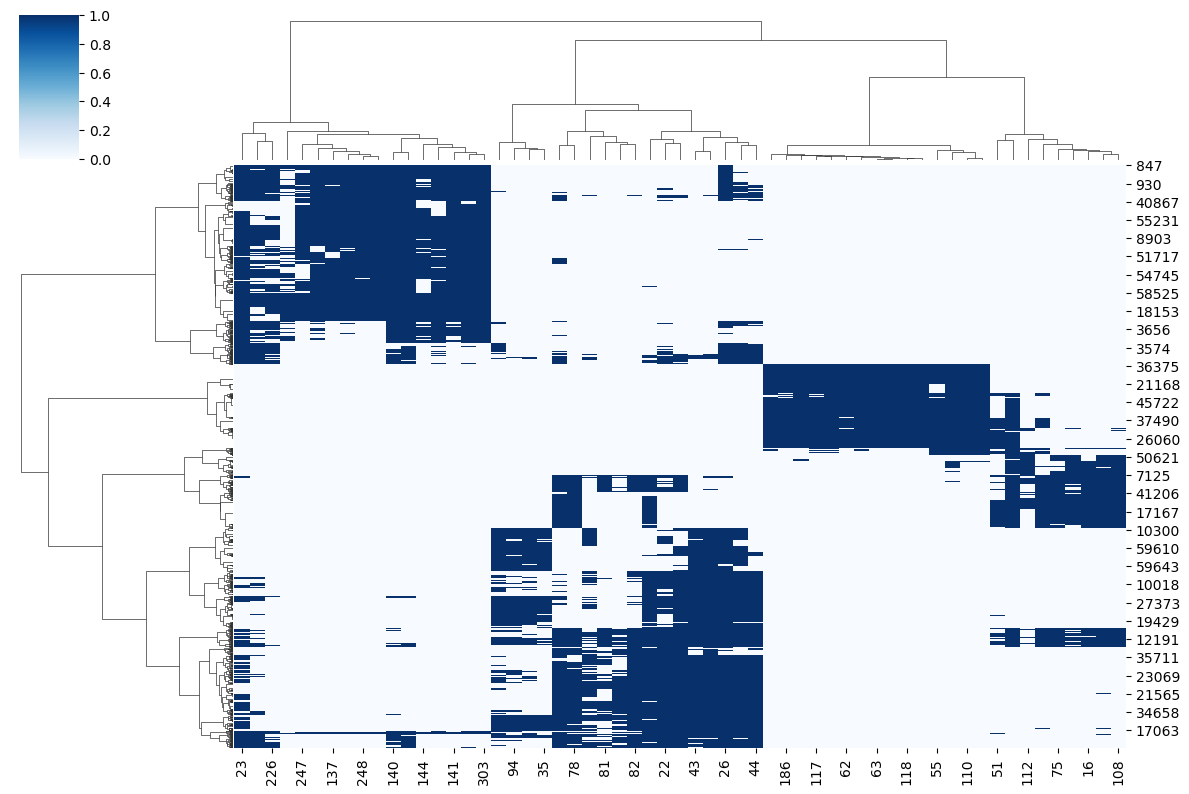

In [13]:
# Cluster the rows in df_pockets_ds_05_wpr_pocket_res based on all columns except the first column using seaborn.clustermap
g = sns.clustermap(df_pockets_ds_05_wpr_pocket_res.iloc[:,1:], metric='euclidean', method='ward', cmap='Blues', figsize=(12,8))

In [14]:
import scipy.cluster.hierarchy as sch

# retrieve clusters using fcluster 
#d = sch.distance.pdist(df_pockets_ds_05_wpr_pocket_res.iloc[:,1:])
#L = sch.linkage(d, method='ward')
L = g.dendrogram_row.linkage
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 200, 'distance')

print('number of clusters: ', len(np.unique(clusters)))
# clusters indicices correspond to incides of original df

number of clusters:  4


In [15]:
df_index = []
cluster_no = []

for i,cluster in enumerate(clusters):
    print(df_pockets_ds_05_wpr_pocket_res.index[i], cluster)
    df_index.append(df_pockets_ds_05_wpr_pocket_res.index[i])
    cluster_no.append(cluster)

1 4
2 1
7 4
15 4
20 1
21 4
25 4
29 1
30 1
31 4
36 4
40 4
41 1
42 4
46 4
49 4
53 4
54 3
58 4
59 4
65 4
66 4
71 4
72 1
76 4
77 1
83 4
86 3
87 4
95 4
99 4
100 1
105 1
111 1
112 4
113 3
114 3
123 1
124 3
125 4
129 4
130 4
134 4
135 1
138 4
150 4
155 4
157 4
166 1
177 1
178 4
179 3
185 4
186 1
193 4
199 4
204 4
206 4
213 4
214 1
220 4
227 1
229 4
233 4
234 4
242 4
243 4
247 3
248 4
252 4
253 4
260 4
262 2
266 4
272 4
279 1
280 4
284 4
285 4
290 4
295 4
296 4
300 4
302 4
309 4
313 4
318 4
323 4
324 4
329 4
330 4
336 4
342 1
351 4
361 4
362 1
367 4
368 4
375 4
380 4
386 4
395 4
396 3
405 4
413 1
414 1
419 3
420 4
427 4
428 4
433 4
438 4
443 4
444 3
445 4
450 4
454 1
460 4
461 4
468 2
469 4
476 3
477 4
479 1
482 4
483 1
484 1
489 1
494 4
498 3
502 4
506 4
513 3
517 4
522 4
528 4
529 1
530 4
536 4
542 4
543 1
544 4
550 3
551 4
559 4
565 1
567 4
570 4
573 4
576 4
578 4
580 1
583 4
590 4
593 3
594 1
595 4
599 1
600 3
601 1
607 1
608 1
614 4
615 1
620 1
626 4
632 1
636 1
643 4
644 4
650 4
651 1
65

In [16]:
df_index_clusters = pandas.DataFrame(list(zip(df_index,clusters)),columns=['Index','cluster_no'])

In [27]:
# For each cluster, get the number of rows in df_pockets_ds_05_wpr_pocket_res that belong to this cluster
for cluster in np.unique(clusters):
    df_index_cluster = df_index_clusters[df_index_clusters['cluster_no'] == cluster]
    index_cluster = df_index_cluster['Index'].tolist()

    # Get the rows in df_pockets_ds_05_wpr that belong to this cluster
    df_pockets_ds_05_wpr_cluster = df_pockets_ds_05_wpr[df_pockets_ds_05_wpr.index.isin(index_cluster)]

    # Get the rows in df_pockets_ds_05_wpr_pocket_res that belong to this cluster
    #df_pockets_ds_05_wpr_pocket_res_cluster = df_pockets_ds_05_wpr_pocket_res[df_pockets_ds_05_wpr_pocket_res.index.isin(index_cluster)]

    # Sort the rows in df_pockets_ds_05_wpr_cluster by descending value of Druggability Score
    df_pockets_ds_05_wpr_cluster = df_pockets_ds_05_wpr_cluster.sort_values(by='drugScore',ascending=False)
    frame = df_pockets_ds_05_wpr_cluster['frame'].tolist()[0]
    pocket_name = df_pockets_ds_05_wpr_cluster['name'].tolist()[0]
    pocket_res = df_pockets_ds_05_wpr_cluster['pocket_res'].tolist()[0]
    drugScore = df_pockets_ds_05_wpr_cluster['drugScore'].tolist()[0]
    print('cluster no: ', cluster)
    print('frame: ', frame)
    print('pocket name: ', pocket_name)
    print('pocket_res: ', pocket_res)
    print('drugScore: ', drugScore)

    # If cluster_pockets folder does not exist, create it
    if not os.path.exists('cluster_pockets'):
        os.makedirs('cluster_pockets')
    
    # Copy 2021_09_21_charmmGUI_norA_splitPDB_dss/frame_{frame}.pdb_gps_{pocket_name}.pdb to cluster_pockets
    shutil.copyfile(f'../data/2021_09_21_charmmGUI_norA_splitPDB_dss/frame_{frame}.pdb_gps_{pocket_name}.pdb', f'cluster_pockets/frame_{frame}.pdb_gps_{pocket_name}.pdb')
    # Copy 2021_09_21_charmmGUI_norA_splitPDB_dss/frame_{frame}.pdb_res_{pocket_name}.pdb to cluster_pockets
    shutil.copyfile(f'../data/2021_09_21_charmmGUI_norA_splitPDB_dss/frame_{frame}.pdb_res_{pocket_name}.pdb', f'cluster_pockets/frame_{frame}.pdb_res_{pocket_name}.pdb')
    # Copy 2021_09_21_charmmGUI_norA_splitPDB/{frame}.pdb to cluster_pockets
    shutil.copyfile(f'../data/2021_09_21_charmmGUI_norA_splitPDB/frame_{frame}.pdb', f'cluster_pockets/frame_{frame}.pdb')

cluster no:  1
frame:  118
pocket name:  P_1_1
pocket_res:  22 23 26 27 30 40 133 134 137 138 140 141 218 219 221 222 223 224 225 226 227 244 245 248 251 252 255 256 303 306 307 310 311
drugScore:  0.923268
cluster no:  2
frame:  8395
pocket name:  P_1_1
pocket_res:  51 55 56 58 59 60 62 63 67 105 106 109 110 113 114 117 118 125 129 132 133 136 183 184 185 186 187 188 189 190 327 330 331 333 334 337
drugScore:  0.902317
cluster no:  3
frame:  1848
pocket name:  P_1_6
pocket_res:  12 15 16 108 109 112 136
drugScore:  0.746029
cluster no:  4
frame:  6891
pocket name:  P_1_1
pocket_res:  18 19 22 23 26 40 43 44 47 78 81 82 85 98 137 140 141 144 159 162 219 221 222 223 225 226 244 247 248 251 255 303 306 307 310 340
drugScore:  0.935977
